# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Minibatch size in the wine dataset
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202208

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [4]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

In [5]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [35]:

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality','residual sugar')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
# data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
# data['boolQuality'][data['quality']>5] = 1

# Re-organize the data: train/test in DataLoaders

In [36]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

In [37]:
dataT

tensor([[-0.5284,  0.9607, -1.3918,  ...,  1.2885, -0.5802, -0.9593],
        [-0.2987,  1.9666, -1.3918,  ..., -0.7237,  0.1278, -0.5833],
        [-0.2987,  1.2960, -1.1860,  ..., -0.3342, -0.0492, -0.5833],
        ...,
        [-1.1600, -0.1012, -0.7228,  ...,  0.7043,  0.5409,  0.5446],
        [-1.3896,  0.6533, -0.7743,  ...,  1.6779,  0.3048, -0.2074],
        [-1.3322, -1.2189,  1.0268,  ...,  0.5096,  0.0098,  0.5446]])

In [38]:
labels

tensor([[-0.4526],
        [ 0.0490],
        [-0.1660],
        ...,
        [-0.1660],
        [-0.3809],
        [ 0.7656]])

In [39]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# Now for the DL part

In [43]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

# Train the model

In [44]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
#   lossfun = nn.BCEWithLogitsLoss()
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( torch.mean(100 - (y-yHat/y)).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    # testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    testAcc.append( torch.mean(100 - (y-yHat/y)).item() )
  
  # function output
  return trainAcc,testAcc,losses

# Now for the experiment

In [45]:
# This cell takes ~15 mins

# range of batch sizes
# batchsizes = 2**np.arange(1,10,2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs))
accuracyResultsTest  = np.zeros((numepochs))
# comptime             = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
# for bi in range(len(batchsizes)):

# start the clock!
# starttime = time.process_time()

# create dataloader object
train_loader = DataLoader(train_dataDataset,
                        batch_size=32, shuffle=True, drop_last=True)

# create and train a model
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()


In [46]:
# store data
accuracyResultsTrain[:] = trainAcc
accuracyResultsTest[:]  = testAcc

# check the timer
# comptime[bi] = time.process_time() - starttime


In [47]:
 X,y = next(iter(test_loader))

 yhat = winenet(X)

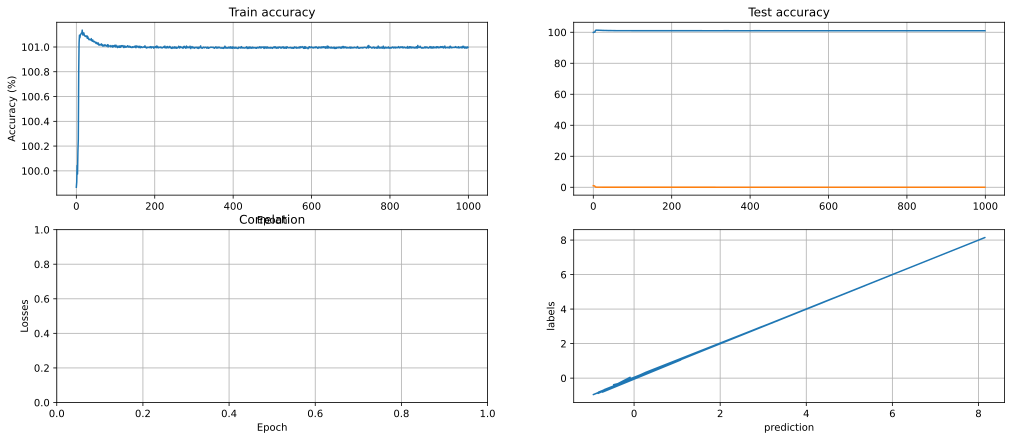

In [48]:
# plot some results
fig,ax = plt.subplots(2,2,figsize=(17,7))

ax[0,0].plot(accuracyResultsTrain)
ax[0,0].set_title('Train accuracy')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Accuracy (%)')

ax[0,1].plot(accuracyResultsTest)
ax[0,1].set_title('Test accuracy')
ax[0,1].plot(losses)
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Accuracy (%)')


ax[1,0].set_title('Losses')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Losses')

ax[1,0].set_title('Correlation')
ax[1,1].plot(yhat.detach(),y)
ax[1,1].set_xlabel('prediction')
ax[1,1].set_ylabel('labels')


# # common features
for i in range(2):
    for j in range(2):
# #   ax[i].legend(batchsizes)
#   ax[i].set_xlabel('Epoch')
#   ax[i].set_ylabel('Accuracy (%)')
# #   ax[i].set_ylim([50,100])
        ax[i,j].grid()

plt.show()

# # bar plot of computation time
# plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
# plt.xlabel('Mini-batch size')
# plt.ylabel('Computation time (s)')
# plt.show()

# Additional explorations

In [ ]:
# 1) There is another regularization technique called "early stopping," which simply means to stop training the model
#    earlier than the number of epochs you specified. Early stopping is used when the test accuracy starts to decrease
#    with increased training. Do you think that early stopping would be beneficial here? How many epochs would you train?
# 
# 2) The training loop computes the losses, but those aren't plotted. Create an additional subplot to show the losses
#    in a similar fashion as the accuracy. Does that plot provide any additional insights into the effects of minibatch
#    size, beyond what we can already learn from the accuracy plots.
# 